# Preparacion de datos

* Nuestra primera tarea sera la de integracion de datos.

En un principio se necesitaba integrar la data de **ieee-github** pero esta ya se encontraba integrada en la data de Kaggle, por lo cual si la usabamos ocasionaria datos duplicados o posibles problemas si esta se usaba para la validacion u otras.

* **iee-github** queda descartado por la **Fase de Compresion de los datos**

##### Observacion:
* Los datos de kaggle en su mayoria ya son datos procesados, en nuestro caso debido a que la mayoria son imagenes medicas, se estima que hayan pasado por un **Algoritmo de segmentacion de imagenes medicas** es posibles que hayan pasado por **U-Net** un algoritmo de inteligencia artificial encargado de dicha segmentacion.

Las imagenes ya estan procesadas de manera en que tienen dimensiones de 256x256 pixeles

In [1]:
#realizamos algunas importaciones de datos
import matplotlib.pyplot as plt
import random
import seaborn as sns; sns.set()
import os
#desarrollamos una funcion para automatizar la muestra de imagenes por condicion de entrada

def show_xrays(path=None,size_img=(3,3),target=None):
    fig,axes=plt.subplots(size_img[0],size_img[1])
    fig.set_size_inches(10,10)
    img_list=os.listdir(path)
    img_list=random.sample(img_list,size_img[0]*size_img[1])
    #plt.axis(False)
    for i,ax in enumerate(axes.flat):
        image=plt.imread(os.path.join(path,img_list[i]))
        ax.imshow(image,cmap="jet",interpolation="nearest")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(f"Imagen {target} -{i+1}")
    plt.show()

Visualizamos algunos datos de COVID-19.

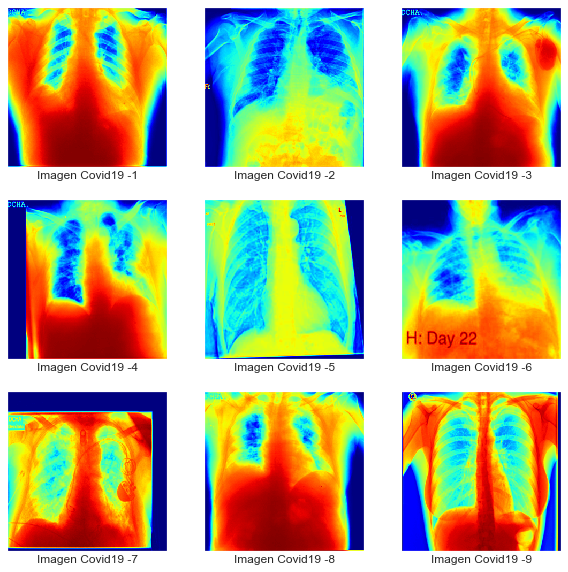

In [2]:
path_covid="../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID"
show_xrays(path_covid,target="Covid19")

* El **escalamiento y normalizacion de datos** se usara como un flujo de **Data Augmentation** durante el entrenamiento de datos

* El **balanceo de datos** se manejara con la implementacion de una funcion de perdida mejorada para penalizar las clases mayoritarias y dar una mejor prioridad a las clases minoritarias.

### Separación de los conjuntos de datos: Entrenamiento | Validacion | Prueba

* El entrenamiento usa el 70% de los datos.
* La validacion usa el 10%.
* La prueba usa el 20%. Este conjunto no se utiliza hasta que se desarrolle el algoritmo completo y funcional, sera una contrastacion con el mundo real.

In [3]:
#usaremos un script para automatizar el proceso de division de datos obteniendo la ruta de cada carpeta.
import pandas as pd
def generate_dataframe_datasets():
    list_target=["COVID","Lung_Opacity","Normal","Viral Pneumonia"]
    dataset={"PATH":[],"LABEL":[]}
    for target in list_target:
        path_general=f"../Datasets/KAGGLE_COVID-19_Radiography_Dataset/{target}"
        list_img=[arch.path for arch in os.scandir(path_general) if arch.is_file()]
        dataset["PATH"].extend(list_img)
        dataset["LABEL"].extend(len(list_img)*[target])
    
    return pd.DataFrame(dataset)

In [30]:
#generar el PATH con las UBICACIONES y LABEL 
data=generate_dataframe_datasets()

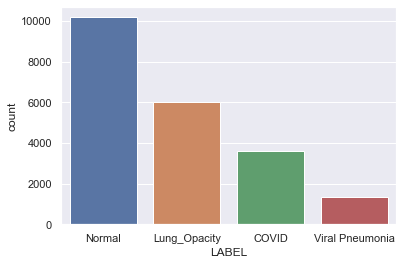

In [5]:
sns.countplot(x="LABEL",data=data,order=data.LABEL.value_counts().index)
plt.show()

Instanciamos la clase **train_test_split** para aprovechar la funcionalidad de division **stratify**

In [6]:
from sklearn.model_selection import train_test_split

train_data,test_data=train_test_split(data,random_state=42,test_size=0.2,shuffle=True,stratify=data.LABEL)
train_data,val_data=train_test_split(train_data,random_state=42,test_size=0.1,shuffle=True,stratify=train_data.LABEL)

In [7]:
#script para comparar la proporcion de clases para cada particion de datos
def plot_distribution_data(data,title=None,ax=None):
    if ax is None:
        fig,(ax)=plt.subplots(1,1)
    g=sns.countplot(x="LABEL",data=data,order=data.LABEL.value_counts().index,ax=ax)
   
    ax.set_title(title)

Mostramos como se dividieron los datos en modo grafico

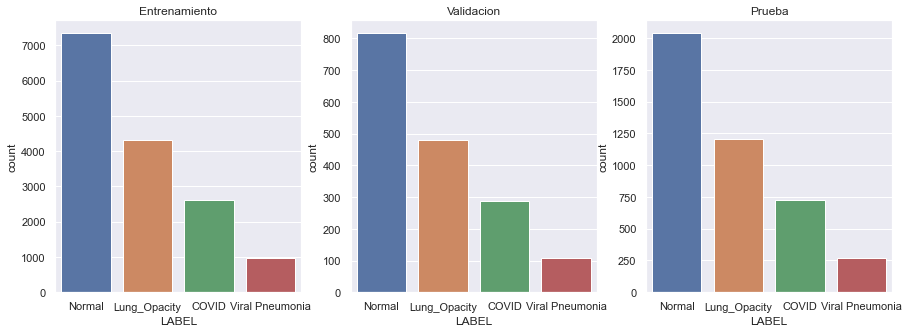

In [8]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3)
fig.set_size_inches(15,5)
plot_distribution_data(train_data,title="Entrenamiento",ax=ax1)
plot_distribution_data(val_data,title="Validacion",ax=ax2)
plot_distribution_data(test_data,title="Prueba",ax=ax3)

Se puede apreciar que hubo una buena division estratificada de datos. Esto es muy util en los problemas de clasificacion

#### PROPORCION DE LOS CONJUNTOS A SEPARAR

In [9]:
print("CONJUNTO DE ENTRENAMIENTO")
display(train_data.LABEL.value_counts(normalize=True,ascending=False).apply(lambda x:f"{x*100:0.2f}%"))
print("CONJUNTO DE VALIDACION")
display(val_data.LABEL.value_counts(normalize=True,ascending=False).apply(lambda x:f"{x*100:0.2f}%"))
print("CONJUNTO DE PRUEBA")
display(test_data.LABEL.value_counts(normalize=True,ascending=False).apply(lambda x:f"{x*100:0.2f}%"))

CONJUNTO DE ENTRENAMIENTO


Normal             48.16%
Lung_Opacity       28.40%
COVID              17.09%
Viral Pneumonia     6.35%
Name: LABEL, dtype: object

CONJUNTO DE VALIDACION


Normal             48.17%
Lung_Opacity       28.39%
COVID              17.06%
Viral Pneumonia     6.38%
Name: LABEL, dtype: object

CONJUNTO DE PRUEBA


Normal             48.15%
Lung_Opacity       28.42%
COVID              17.08%
Viral Pneumonia     6.35%
Name: LABEL, dtype: object

#### NUMERO DE ELEMENTOSxCLASE DE LOS CONJUNTOS A SEPARAR


In [10]:
print("CONJUNTO DE ENTRENAMIENTO")
display(train_data.LABEL.value_counts(ascending=False))
print("CONJUNTO DE VALIDACION")
display(val_data.LABEL.value_counts(ascending=False))
print("CONJUNTO DE PRUEBA")
display(test_data.LABEL.value_counts(ascending=False))

CONJUNTO DE ENTRENAMIENTO


Normal             7338
Lung_Opacity       4328
COVID              2604
Viral Pneumonia     968
Name: LABEL, dtype: int64

CONJUNTO DE VALIDACION


Normal             816
Lung_Opacity       481
COVID              289
Viral Pneumonia    108
Name: LABEL, dtype: int64

CONJUNTO DE PRUEBA


Normal             2038
Lung_Opacity       1203
COVID               723
Viral Pneumonia     269
Name: LABEL, dtype: int64

* Como es ideal, ahora los conjuntos que se dividiran tendran igual proporcion de clases, y eso evitara el sesgo en los datos, debido a que el modelo ahora vera la misma cantidad por igual.

Ahora desarrollamos el algoritmo de migracion de carpetas genericas a las destinadas train,val,test

In [24]:
import shutil
train_data.reset_index(drop=True,inplace=True)
val_data.reset_index(drop=True,inplace=True)
test_data.reset_index(drop=True,inplace=True)

def split_data_by_info(data_info=list(),dest_path="."):
    for tipo,df in data_info:
        ruta=os.path.join(dest_path,tipo)
        if not os.path.exists(ruta): #si no existe la ruta, entonces la crea
            os.mkdir(ruta) #crear ruta
            print(f"Directorio {tipo} CREADO")
        #recorrer todo el dataset de informacion de rutas
        for i in range(df.LABEL.count()):
            subdir_name=df.loc[i,"LABEL"]
            subdir_path=os.path.join(ruta,subdir_name) 
            if not os.path.exists(subdir_path): #si no existe entonces la crea
                os.mkdir(subdir_path)
                print(f"Subdirectorio {subdir_name} CREADO")
            ruta_img=df.loc[i,"PATH"]
            print(f"Moviendo {ruta_img} -> {subdir_path}")
            shutil.move(ruta_img,subdir_path)


In [25]:
data_info=[("train",train_data),("val",val_data),("test",test_data)]
dest_path="../Datasets/"


In [ ]:
split_data_by_info(data_info,dest_path)#la separacion se ejecuta correctamente.

* La separacion de datos esta lista. Ahora nos vamos a la fase de modelado